# Featurized the sgRNA

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import time
import sklearn
import numpy as np
import Bio.SeqUtils as SeqUtil
import Bio.Seq as Seq
# import azimuth.util
import sys
import Bio.SeqUtils.MeltingTemp as Tm
import pickle
import itertools
from sklearn.preprocessing import MinMaxScaler
import sklearn
import sklearn.linear_model
from sklearn.grid_search import GridSearchCV
import sklearn.ensemble as en
import scipy.stats as st
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import scipy as sp


D:\Anaconda3_new\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3_new\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [17]:

def cal_deltaG(seq_file,cal_deltaG_dir,input_seq=False):
    if input_seq == False:
        items=seq_file.split(">")[1:]
        seqs=[]
        for item in items:
            item=item.strip()
            seq=item.split("\n")[1]
            seqs.append(seq)
        get_20mer=lambda x : x[4:24]
#     map(get_20mer,seqs)
        seqs_20mer=[]
        for i in map(get_20mer,seqs):
            seqs_20mer.append(i)
        for_deltaG=";".join(seqs_20mer)
    
    elif input_seq == True:
        #seq_file
        #seqs_20mer=[]
        #for argv in sys.argv[1:]:
        #    assert len(argv)==30, "the sequence input must be 30mer"
        #    seqs_20mer.append(argv)
        for_deltaG=";".join(seq_file)
    for_deltaG_dir=os.path.join(cal_deltaG_dir,"for_deltaG.txt")
    with open(for_deltaG_dir,"w") as f2:
        f2.write(for_deltaG)
#     for_deltaG_dir=os.path.join(current_dir,)
    deltaG_result_dir=os.path.join(cal_deltaG_dir,"deltaG_result.txt")
    os.system("hybrid-ss-min -E %s -o %s" % (for_deltaG_dir,deltaG_result_dir))
    if os.path.exists(deltaG_result_dir)=="False":
        print("the %s is not exists" % deltaG_result_dir)
    return deltaG_result_dir+".dG"    
start=time.time()
##featurazation
def get_alphabet(order,raw_alphabet=["A","G","C","T"]):##
    alphabet=["".join(i) for i in itertools.product(raw_alphabet,repeat=order)]
    return alphabet
def genera_nucleotide_features(s,order,prefix="",feature_type="all",raw_alphabet=["A","T","G","C"],NGGX=False):##
    alphabet=get_alphabet(order,raw_alphabet=raw_alphabet)
    features_pos_dependent=np.zeros(len(alphabet)*(len(s)-(order-1)))
    features_pos_independent=np.zeros(np.power(len(raw_alphabet),order))
    index_dependent=[]
    index_independent=[]
    
    for position in range(0,(len(s)-order+1),1):
        if NGGX==False:
            for i in alphabet:
#                 exg=position-3
                if position<=3:
                    exg=position-4
                elif position>3:
                    exg=position-3
                
                index_dependent.append("%s%s_%s" % (prefix,i,exg))
        else:
            for i in alphabet:
                index_dependent.append("NGGX%s%s_%s" % (prefix,i,position))
    for i in alphabet:
        index_independent.append("%s%s" % (prefix,i))
    for position in range(0,(len(s)-order+1),1):
        nucl=s[position:position+order]
        features_pos_dependent[alphabet.index(nucl)+(position*len(alphabet))]=1.0
        features_pos_independent[alphabet.index(nucl)]+=1.0
    if feature_type=="all" or feature_type=="pos_independent":
        if feature_type=="all":
            res=pd.Series(features_pos_dependent,index=index_dependent),pd.Series(features_pos_independent,index=index_independent)
            return res
        else:
            res=pd.Series(features_pos_independent,index=index_independent)
            return res
    res=pd.Series(features_pos_dependent,index=index_dependent)#
    return res
def nucleotide_features_dictionary(prefix=""):
    seqname=["-4","-3","-2","-1"]
    seqname.extend([str(i) for i in range(1,21)])#
    seqname.extend(["N","G","G","+1","+2","+3"])
    orders=[1,2,3]
    sequence_len=30
    feature_names_dep=[]
    feature_names_indep=[]
    index_dependent=[]
    index_independent=[]
    for  order in orders:
        raw_alphabet=["A","G","C","T"]
        alphabet=["".join(i)for i in itertools.product(raw_alphabet,repeat=order)]
        feature_pos_dependent=np.zeros(len(alphabet)*(sequence_len-order+1))
        feature_pos_independent=np.zeros(np.power(len(raw_alphabet),order))
        index_dependent.extend(["%s_pd.Order%s_P%d" % (prefix,order,i) for i in range(len(feature_pos_dependent))])
        index_independent.extend(["%s_pi.Order%s_P%d" % (prefix,order,i) for i in range(len(feature_pos_independent))])
        for pos in range(sequence_len-(order-1)) :
            for letter in alphabet:
                feature_names_dep.append("%s_%s" % (letter,seqname[pos]))
        for letter in alphabet:
            feature_names_indep.append("%s" % letter)
    index_all=index_dependent+index_independent
    feature_all=feature_names_dep+feature_names_indep
    return dict(zip(index_all,feature_all))#

def NGGX_interaction_feature(s):
    sequence=s
    NX=sequence[25]+sequence[27]
    NX_onehot=genera_nucleotide_features(NX,order=2,feature_type="pos_dependent",NGGX=True)
#     feat_NX=pandas.concat([feat_NX,NX_onehot],axis=1)
    return NX_onehot
def apply_NGGX_feature(data):
    NGGX_feat=data["30mer"].apply(NGGX_interaction_feature)
    return NGGX_feat
def gc_percent(seq):
    return (seq.count('G') + seq.count('C'))/float(len(seq))
def countGC_20mer(s, length_audit=True):
    if length_audit:
        assert len(s) == 30, "seems to assume 30mer"
    return s.count("G")+s.count("C")
def gc_features(data, audit=True):
    gc_count=data["30mer"].apply(lambda seq:countGC_20mer(seq, audit))
    gc_count.name="gc_count"
    gc_above_10=(gc_count>10)*1
    gc_above_10.name="gc_above_10"
    gc_below_10=(gc_count<10)*1
    gc_below_10.name="gc_below_10"
    data["gc_count"]=gc_count
    data["gc_above_10"]= gc_above_10 
    data["gc_below_10"]=gc_below_10
    return gc_above_10, gc_below_10, gc_count
def filter_no_30mer(data):
    data["30mer"]=data["30mer"].apply(lambda x: x[0:30])
    return data
def Tm_feature(data,pam_audit=True,learn_options=None):
    if learn_options is None or "Tm segments" not in learn_options:
        segments=[(19,24),(11,19),(6,11),(4,24)]
    else:
        segments=learn_options["Tm segments"]
    sequence=data["30mer"].values
    featarray=np.ones((sequence.shape[0],5))
    for i,seq in  enumerate(sequence):
        if pam_audit and seq[25:27]!="GG":
            continue
            raise Exception("excepted GG but found %s" % seq[25:27])
        rna=True
        featarray[i,0]=Tm.Tm_staluc(seq,rna=rna)#30mer
        featarray[i,1]=Tm.Tm_staluc(seq[segments[0][0]:segments[0][1]], rna=rna) #5nts immediately proximal of the NGG PAM
        featarray[i,2]=Tm.Tm_staluc(seq[segments[1][0]:segments[1][1]], rna=rna)   #8-mer
        featarray[i,3]=Tm.Tm_staluc(seq[segments[2][0]:segments[2][1]], rna=rna)      #5-mer
        featarray[i,4]=Tm.Tm_staluc(seq[segments[3][0]:segments[3][1]], rna=rna) #20-spacer
    feat=pd.DataFrame(featarray,index=data.index,columns=["Tm global_30mer%s" % rna, "5mer_end_%s" %rna, "8mer_middle_%s" %rna, "5mer_start_%s" %rna,"Tm global_spacer_%s" % rna])                            
    return feat





def apply_nucleotide_features(seq_data_frame,order,include_pos_independent,prefix=""):                                                                                                              
    if include_pos_independent:
        feat_pd = seq_data_frame.apply(genera_nucleotide_features, args=(order, prefix, 'pos_dependent'))
        feat_pi = seq_data_frame.apply(genera_nucleotide_features, args=(order, prefix, 'pos_independent'))
        return feat_pd,feat_pi 
    else:
        feat_pd = seq_data_frame.apply(genera_nucleotide_features, args=(order, prefix, 'pos_dependent'))
        return feat_pd
def get_all_order_nuc_features(data,feature_sets,maxorder, max_index_to_use, prefix=""): 
    for order in range(1, maxorder+1):
        nuc_features_pd, nuc_features_pi = apply_nucleotide_features(data, order,prefix=prefix)
        return  nuc_features_pd, nuc_features_pi
def concat_all_need_feat(data):
    
    gc_count=gc_features(filter_no_30mer(data), audit=True)[2]##Series
    gc_above_10=gc_features(filter_no_30mer(data), audit=True)[0]##Series
    gc_below_10=gc_features(filter_no_30mer(data), audit=True)[1]##Series
    pair_base_pd=apply_nucleotide_features(filter_no_30mer(data)["30mer"],order=2,prefix="",include_pos_independent=False)##df
    single_base_pd=apply_nucleotide_features(filter_no_30mer(data)["30mer"],order=1,prefix="",include_pos_independent=False)##df
    pair_base_pi=apply_nucleotide_features(filter_no_30mer(data)["30mer"],order=2,prefix="",include_pos_independent=True)[1]##tuple
#     return pair_base_pi
    single_base_pi=apply_nucleotide_features(filter_no_30mer(data)["30mer"],order=1,prefix="",include_pos_independent=True)[1]##tuple
#     return single_base_pi
#     return type(single_base_pi)
    Tm=Tm_feature(filter_no_30mer(data),pam_audit=True,learn_options=None)##df
    NGGX=apply_NGGX_feature(data)
#     return type(Tm)
    all_need_feat=pd.concat([gc_count,gc_above_10,gc_below_10,pair_base_pd,single_base_pd,pair_base_pi,single_base_pi,Tm,NGGX],axis=1)
    return all_need_feat
##add other features
def five_continuous_base(data):
    sequence=data["30mer"].values
    five_con_A=np.zeros(len(sequence))
    five_con_G=np.zeros(len(sequence))
    five_con_C=np.zeros(len(sequence))
    five_con_T=np.zeros(len(sequence))
    for index,seq in enumerate(sequence):
        if "AAAAA" in seq.upper():
            five_con_A[index]=1
        elif "TTTTT" in seq.upper():
            five_con_T[index]=1
        elif "GGGGG" in seq.upper():
            five_con_G[index]=1
        elif "CCCCC" in seq.upper():
            five_con_C[index]=1
    all_continue=np.vstack((five_con_A,five_con_G,five_con_C,five_con_T))
    
    add_five_con=pd.DataFrame(all_continue.transpose(),index=data.index,columns=["AAAAA", "TTTTT","GGGGG","CCCCC"])
    return add_five_con
#     add_five_con=pd.concat([data,continue_feat],axis=1)

#     return add_five_con
def apply_three_contiu(seq_data_frame,order,include_pos_independent=True,prefix=""):                                                                                                              
    if include_pos_independent:
        feat_pd_three_contiu = seq_data_frame.apply(genera_nucleotide_features, args=(order, prefix, 'pos_dependent'))
#         return feat_pd
        feat_pi_three_contiu = seq_data_frame.apply(genera_nucleotide_features, args=(order, prefix, 'pos_independent'))
        
        return feat_pd_three_contiu,feat_pi_three_contiu
#     else:
#         feat_pd = seq_data_frame.apply(genera_nucleotide_features, args=(order, prefix, 'pos_dependent'))
#         assert not np.any(np.isnan(feat_pd)), "found nan in feat_pd"
        return feat_pd
def deltaG_20mer(data,deltaG_result):
    deltaG_value=[]
    deltaG_df=pd.DataFrame(deltaG_result,index=data.index)
    deltaG_df.columns=["DeltaG"]
    return deltaG_df
def concat_all_need_feat_second(data,deltaG_result):#每次改变这里要改
    feat_pd_three_contiu=apply_three_contiu(filter_no_30mer(data)["30mer"],order=3,include_pos_independent=True,prefix="")[0]
    feat_pi_three_contiu=apply_three_contiu(filter_no_30mer(data)["30mer"],order=3,include_pos_independent=True,prefix="")[1]
    deltaG_df=deltaG_20mer(data,deltaG_result)
        #exp_type=diff_exp(data,whose)
    all_need_feat_second=pd.concat([concat_all_need_feat(data),feat_pi_three_contiu,feat_pd_three_contiu,deltaG_df],axis=1)
    return all_need_feat_second
def series_to_df(Series):
    df=pd.DataFrame(data=Series,columns=["30mer"])
    return df

# Generating feature matrix for ABE

In [36]:
%%time
#get the table

#----------------------------main----------------------------------

if __name__=="__main__":
    path="C://Users//23008//Desktop//Lar研究所期间//trap//data//ABE//ABE_efficiency.xlsx"
    this_table=pd.read_excel(path,header=0,sheet_name="Sheet2")
    need_seq_30=this_table["TrapSeq"].apply(lambda x: x[6:36]).values
    seq_df=pd.DataFrame(data=need_seq_30,columns=["30mer"])
    deltaG_result=this_table["Free Energy(kcal/mol)"]
    feature_mt_ABE=concat_all_need_feat_second(seq_df,deltaG_result)

# this_input=get_input(list_input,deltaG_result_dir,input_seq=True)

Wall time: 2min 14s


# Get need sites for ABE

In [41]:
gRNA_site=["N%d(N%d)" % (i,i-10) for i in range(13,22)]
need_site_dict={}
for site in gRNA_site:
    need_site=np.where(this_table[site]!="-")
    need_site_dict[site]=need_site[0]
print(need_site_dict)
pickle.dump(need_site_dict,open("C://Users//23008//Desktop//Lar研究所期间//trap//need_site//ABE_need_site_dict.pickle","wb"))

{'N13(N3)': array([    0,     2,     5, ..., 11983, 11987, 11989], dtype=int64), 'N14(N4)': array([    0,     8,    16, ..., 11988, 11989, 11990], dtype=int64), 'N15(N5)': array([    2,     5,     6, ..., 11984, 11986, 11987], dtype=int64), 'N16(N6)': array([    0,     1,     5, ..., 11981, 11983, 11988], dtype=int64), 'N17(N7)': array([    6,     7,    10, ..., 11985, 11987, 11989], dtype=int64), 'N18(N8)': array([    0,     3,     8, ..., 11984, 11985, 11990], dtype=int64), 'N19(N9)': array([    0,     8,    11, ..., 11985, 11988, 11989], dtype=int64), 'N20(N10)': array([    3,     4,     5, ..., 11984, 11985, 11988], dtype=int64), 'N21(N11)': array([    3,     4,     8, ..., 11982, 11987, 11988], dtype=int64)}


# save ABE feature

In [38]:
feature_mt_ABE.to_csv("C://Users//23008//Desktop//Lar研究所期间//trap//featurization//feature_matrix_ABE_all.csv",sep=",")
pickle.dump(feature_mt_ABE,open("C://Users//23008//Desktop//Lar研究所期间//trap//featurization//feature_matrix_ABE_all.pickle","wb"))

# plot need site

[array([    0,     2,     5, ..., 11983, 11987, 11989], dtype=int64), array([    0,     8,    16, ..., 11988, 11989, 11990], dtype=int64), array([    2,     5,     6, ..., 11984, 11986, 11987], dtype=int64), array([    0,     1,     5, ..., 11981, 11983, 11988], dtype=int64), array([    6,     7,    10, ..., 11985, 11987, 11989], dtype=int64), array([    0,     3,     8, ..., 11984, 11985, 11990], dtype=int64), array([    0,     8,    11, ..., 11985, 11988, 11989], dtype=int64), array([    3,     4,     5, ..., 11984, 11985, 11988], dtype=int64), array([    3,     4,     8, ..., 11982, 11987, 11988], dtype=int64)]
['N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11']


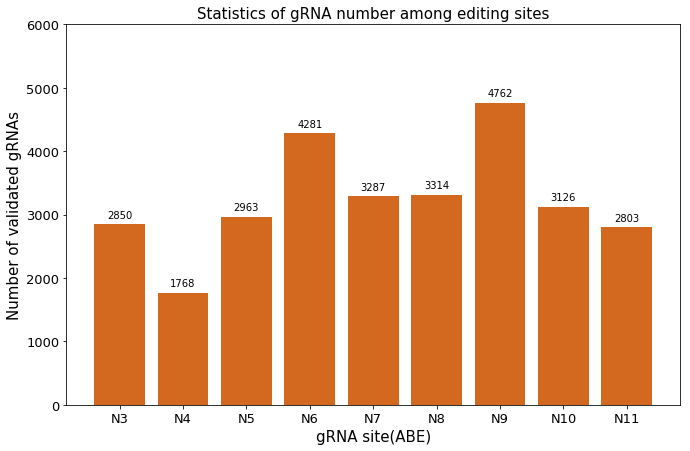

[2850, 1768, 2963, 4281, 3287, 3314, 4762, 3126, 2803]


In [81]:
need_site_list_ABE=[]
ABE_site_list=[]
root=os.getcwd()
pj=lambda *path: os.path.abspath(os.path.join(*path))
for site in range(13,22):
    need_site=pickle.load(open(pj("C://Users//23008//Desktop//Lar研究所期间//trap//data//ABE//","N%d_used.pickle" % site),"rb"))
    need_site_list_ABE.append(need_site)
    ABE_site_list.append("N%d" % (site-10))
print(need_site_list_ABE)
print(ABE_site_list)


x_axis=[i for i in range(len(ABE_site_list))]
x_axis_lb=ABE_site_list
y_axis=[len(i) for i in need_site_list_ABE]
fig=plt.figure(figsize=(11,7))
   

plt.xticks(range(len(x_axis_lb)),x_axis_lb)
# plt.yticks(range(len(y_axis)),y_axis)
plt.bar(x_axis,y_axis,color="chocolate")
plt.ylim((0,6000))
for index,site in enumerate(x_axis):
    text_x=x_axis[index]
    text_y=y_axis[index]+100
    plt.text(text_x,text_y,str(y_axis[index]),horizontalalignment='center')
plt.xlabel("gRNA site(ABE)",fontsize=15) 
plt.tick_params(labelsize=13)
plt.ylabel("Number of validated gRNAs",fontsize=15)
plt.title("Statistics of gRNA number among editing sites",fontsize=15)
plt.savefig("C://Users//23008//Desktop//Lar研究所期间//trap//figure//ABE//site_num.pdf",typ="pdf")
plt.show()
print(y_axis)

# Trap seq to fasta file

In [4]:
def to_fasta(seq_list):
    seq_str=""
    n=1
    for seq in seq_list:
        seq_str+=">%d\n" % n+seq[10:30]+"\n"
        n+=1
    with open("C://Users//23008//Desktop//Lar研究所期间//trap//data//ABE//ABE_seq_fasta.fasta","w") as f1:
        f1.write(seq_str)
path="C://Users//23008//Desktop//Lar研究所期间//trap//data//ABE//ABE_efficiency.xlsx"
this_table=pd.read_excel(path,header=0,sheet_name="Sheet2")
trap_seq=this_table["TrapSeq"]
to_fasta(trap_seq)


In [ ]:
df.to_csv()

# Generate feature matrix for CBE

In [27]:
%%time
#get the table
if __name__=="__main__":
    path="C://Users//23008//Desktop//Lar研究所期间//trap//data//CBE//TRAP-12K CBE.xlsx"
    this_table=pd.read_excel(path,header=0)
    need_seq_30=this_table["TrapSeq"].apply(lambda x: x[6:36]).values
    seq_df=pd.DataFrame(data=need_seq_30,columns=["30mer"])
    deltaG_result=this_table["Free Energy(kcal/mol)"]
    feature_mt_CBE=concat_all_need_feat_second(seq_df,deltaG_result)


Wall time: 1min 59s


# Save CBE feature matrix

In [142]:
# pickle.dump(feature_mt,open("C://Users//23008//Desktop//Lar研究所期间//trap//featurization//feature_matrix_CBE.pickle","wb"))
feature_mt.to_csv("C://Users//23008//Desktop//Lar研究所期间//trap//featurization//feature_matrix_CBE.txt",sep=" ")

In [28]:
pickle.dump(feature_mt,open("C://Users//23008//Desktop//Lar研究所期间//trap//featurization//feature_matrix_CBE.pickle","wb"))

In [145]:
feature_mt=pd.read_table("C://Users//23008//Desktop//Lar研究所期间//trap//featurization//feature_matrix_CBE.txt",sep=" ",index_col=[0])

# get CBE need site

In [6]:
gRNA_site=["N%d" % i for i in range(1,21)]
need_site_dict={}
for site in gRNA_site:
    need_site=np.where(this_table[site]!="-")
    need_site_dict[site]=need_site[0]
print(need_site_dict)
pickle.dump(need_site_dict,open("C://Users//23008//Desktop//Lar研究所期间//trap//need_site//CBE_need_site_dict.pickle","wb"))

{'N1': array([    0,     2,     5, ..., 11863, 11868, 11869], dtype=int64), 'N2': array([    4,     7,    15, ..., 11870, 11871, 11874], dtype=int64), 'N3': array([    6,     7,    18, ..., 11861, 11864, 11874], dtype=int64), 'N4': array([    0,     3,     5, ..., 11869, 11871, 11873], dtype=int64), 'N5': array([    2,     3,     4, ..., 11869, 11873, 11874], dtype=int64), 'N6': array([    2,     9,    10, ..., 11860, 11863, 11872], dtype=int64), 'N7': array([    0,     1,     3, ..., 11863, 11864, 11867], dtype=int64), 'N8': array([    4,     6,     7, ..., 11865, 11867, 11872], dtype=int64), 'N9': array([    2,     3,     4, ..., 11953, 11959, 11962], dtype=int64), 'N10': array([    0,     5,    15, ..., 11954, 11956, 11960], dtype=int64), 'N11': array([    9,    11,    15, ..., 11940, 11949, 11955], dtype=int64), 'N12': array([    6,     7,    15, ..., 11957, 11961, 11962], dtype=int64), 'N13': array([    1,     2,     4, ..., 11959, 11960, 11961], dtype=int64), 'N14': array([    0,

In [29]:
need_site_list

[('N1', array([    0,     2,     5, ..., 11863, 11868, 11869], dtype=int64)),
 ('N2', array([    4,     7,    15, ..., 11870, 11871, 11874], dtype=int64)),
 ('N3', array([    6,     7,    18, ..., 11861, 11864, 11874], dtype=int64)),
 ('N4', array([    0,     3,     5, ..., 11869, 11871, 11873], dtype=int64)),
 ('N5', array([    2,     3,     4, ..., 11869, 11873, 11874], dtype=int64)),
 ('N6', array([    2,     9,    10, ..., 11860, 11863, 11872], dtype=int64)),
 ('N7', array([    0,     1,     3, ..., 11863, 11864, 11867], dtype=int64)),
 ('N8', array([    4,     6,     7, ..., 11865, 11867, 11872], dtype=int64)),
 ('N9', array([    2,     3,     4, ..., 11953, 11959, 11962], dtype=int64)),
 ('N10', array([    0,     5,    15, ..., 11954, 11956, 11960], dtype=int64)),
 ('N11', array([    9,    11,    15, ..., 11940, 11949, 11955], dtype=int64)),
 ('N12', array([    6,     7,    15, ..., 11957, 11961, 11962], dtype=int64)),
 ('N13', array([    1,     2,     4, ..., 11959, 11960, 11961

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


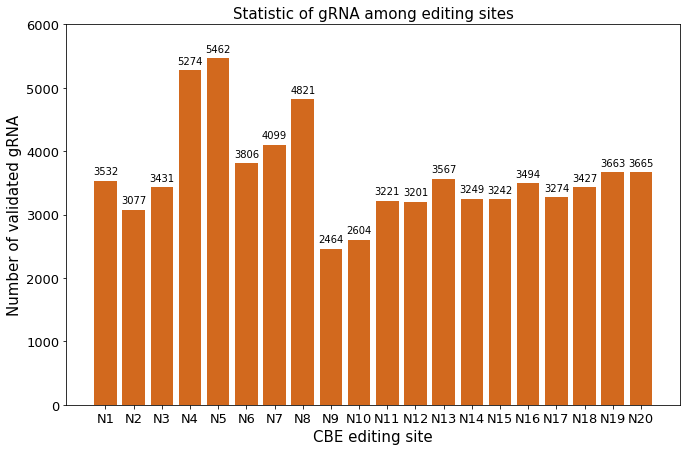

In [65]:
from pylab import *
need_site_list=sorted(need_site_dict.items(),key=lambda x:int(x[0].split("N")[1]))
need_site_list
x_axis=[int(i[0][1:]) for i in need_site_list]
x_axis_lb=["N"+str(i[0][1:]) for i in need_site_list]
y_axis=[len(i[1]) for i in need_site_list]
fig=plt.figure(figsize=(11,7))
   

plt.xticks(range(1,len(x_axis_lb)+1),x_axis_lb)
# plt.yticks(range(len(y_axis)),y_axis)
print(x_axis)
plt.bar(x_axis,y_axis,color="chocolate")
plt.ylim((0,6000))
for index,site in enumerate(x_axis):
    text_x=x_axis[index]
    text_y=y_axis[index]+100
    plt.text(text_x,text_y,str(y_axis[index]),horizontalalignment='center')
plt.xlabel("CBE editing site",fontsize=15) 
plt.tick_params(labelsize=13)
plt.ylabel("Number of validated gRNA",fontsize=15)
plt.title("Statistic of gRNA among editing sites",fontsize=15)
plt.savefig("C://Users//23008//Desktop//Lar研究所期间//trap//figure//CBE//site_num.pdf",typ="pdf")
plt.show()


# Get all in one need sites

In [47]:
AIO=pd.read_excel("C://Users//23008//Desktop//Lar研究所期间//trap//data//all_in_one//all_in_one.xlsx")
Cas9_need=np.where(~AIO["#spCas9-507"].isna())
ABE_need=np.where(~AIO["#ABE-515"].isna())
CBE_need=np.where(~AIO["#CBE-508"].isna())
# np.where(Cas9_need!=None)
need_dict={}
need_dict["Cas9"]=Cas9_need[0]
need_dict["ABE"]=ABE_need[0]
need_dict["CBE"]=CBE_need[0]
pickle.dump(need_dict,open("C://Users//23008//Desktop//Lar研究所期间//trap//need_site//need_dict_alltyp.pickle","wb"))
# pickle.dump(Cas9_need[0],open("C://Users//23008//Desktop//Lar研究所期间//trap//need_site//Cas9_need_allsite.pickle","wb"))
# pickle.dump(ABE_need[0],open("C://Users//23008//Desktop//Lar研究所期间//trap//need_site//ABE_need_allsite.pickle","wb"))
# pickle.dump(CBE_need[0],open("C://Users//23008//Desktop//Lar研究所期间//trap//need_site//CBE_need_allsite.pickle","wb"))

In [ ]:
##plot all in one need site

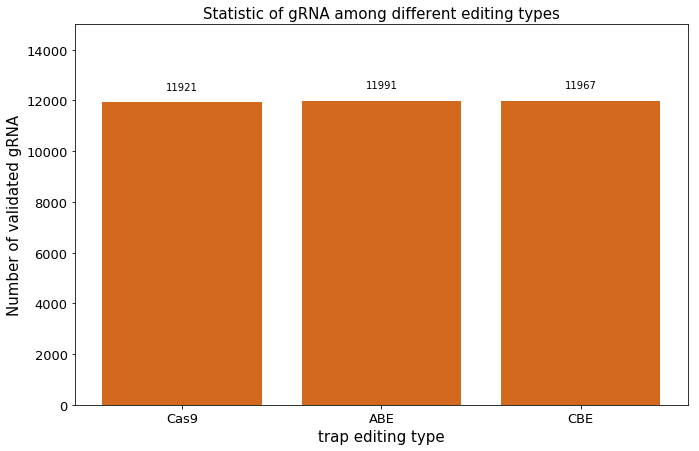

In [69]:
x_axis=["Cas9","ABE","CBE"]
x=[i for i in range(3)]
y_axis=[len(need_dict["Cas9"]),len(need_dict["ABE"]),len(need_dict["CBE"])]
fig=plt.figure(figsize=(11,7))
plt.xticks(range(len(x_axis)),x_axis)
plt.bar(x,y_axis,color="chocolate")
plt.ylim((0,15000))
for index,site in enumerate(x_axis):
    text_x=x[index]
    text_y=y_axis[index]+500
    plt.text(text_x,text_y,str(y_axis[index]),horizontalalignment='center')
plt.xlabel("trap editing type",fontsize=15) 
plt.tick_params(labelsize=13)
plt.ylabel("Number of validated gRNA",fontsize=15)
plt.title("Statistic of gRNA among different editing types",fontsize=15)
plt.savefig("C://Users//23008//Desktop//Lar研究所期间//trap//figure//AIO//site_num.pdf",typ="pdf")
plt.show()